# Multi-Class Image Classification Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 1
### David Lowe
### November 24, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: [Sample Paragraph - The Rock Paper Scissors dataset contains images from a variety of different hand poses with different races, ages, and genders. These images have all been generated using CGI techniques as an experiment in determining if a CGI-based dataset can be used for classification against real photos. All of this data is posed against a white background, and each image is 300×300 pixels in 24-bit color.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved an accuracy score of 93.33% after 20 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 97.91%. Furthermore, the final model processed the test dataset with an accuracy measurement of 100.00%.]

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: [http://www.laurencemoroney.com/rock-paper-scissors-dataset/]

One potential source of performance benchmarks: [http://www.laurencemoroney.com/rock-paper-scissors-dataset/]

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [47]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [48]:
# # Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [49]:
# # Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [50]:
# # Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [51]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [52]:
# Set the random seed number for reproducible results
seedNum = 888

In [53]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import boto3
import zipfile
from datetime import datetime
from dotenv import load_dotenv
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [54]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set various default modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 20
default_batch = 32
default_image_size = (150, 150)
input_image_shape = (150, 150, 3)
num_classes = 3

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.3.0


In [55]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [56]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [57]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [58]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [59]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [60]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [61]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm rps.zip
!rm rps-test-set.zip

In [62]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps.zip

--2020-11-13 20:36:38--  https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.143.9, 13.225.143.95, 13.225.143.78, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.143.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M  36.8MB/s    in 5.3s    

2020-11-13 20:36:44 (35.9 MB/s) - ‘rps.zip’ saved [200682221/200682221]



In [63]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps-test-set.zip

--2020-11-13 20:36:46--  https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps-test-set.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.143.129, 13.225.143.9, 13.225.143.95, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.143.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.zip’

rps-test-set.zip    100%[===================>]  28.15M  16.8MB/s    in 1.7s    

2020-11-13 20:36:48 (16.8 MB/s) - ‘rps-test-set.zip’ saved [29516758/29516758]



In [64]:
staging_dir = 'staging/'
!mkdir staging/

In [65]:
# Unzip and put the files into the staging folder
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
local_zip = 'rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
zip_ref.close()

In [66]:
training_dir = 'staging/rps/'
validation_dir = 'staging/rps-test-set/'
class1_name = 'rock'
class2_name = 'paper'
class3_name = 'scissors'

In [67]:
# Brief listing of training image files for class 1
training_class1_dir = os.path.join(training_dir, class1_name)
training_class1_files = os.listdir(training_class1_dir)
print('Number of training images for', class1_name, ':', len(os.listdir(training_class1_dir)))
print('Training samples for', class1_name, ':', training_class1_files[:10])

# Brief listing of training image files for class 2
training_class2_dir = os.path.join(training_dir, class2_name)
training_class2_files = os.listdir(training_class2_dir)
print('Number of training images for', class2_name, ':', len(os.listdir(training_class2_dir)))
print('Training samples for', class2_name, ':', training_class2_files[:10])

# Brief listing of training image files for class 3
training_class3_dir = os.path.join(training_dir, class3_name)
training_class3_files = os.listdir(training_class3_dir)
print('Number of training images for', class3_name, ':', len(os.listdir(training_class3_dir)))
print('Training samples for', class3_name, ':', training_class3_files[:10])

Number of training images for rock : 840
Training samples for rock : ['rock01-000.png', 'rock01-001.png', 'rock01-002.png', 'rock01-003.png', 'rock01-004.png', 'rock01-005.png', 'rock01-006.png', 'rock01-007.png', 'rock01-008.png', 'rock01-009.png']
Number of training images for paper : 840
Training samples for paper : ['paper01-000.png', 'paper01-001.png', 'paper01-002.png', 'paper01-003.png', 'paper01-004.png', 'paper01-005.png', 'paper01-006.png', 'paper01-007.png', 'paper01-008.png', 'paper01-009.png']
Number of training images for scissors : 840
Training samples for scissors : ['scissors01-000.png', 'scissors01-001.png', 'scissors01-002.png', 'scissors01-003.png', 'scissors01-004.png', 'scissors01-005.png', 'scissors01-006.png', 'scissors01-007.png', 'scissors01-008.png', 'scissors01-009.png']


In [68]:
# Brief listing of validation image files for class 1
validation_class1_dir = os.path.join(validation_dir, class1_name)
validation_class1_files = os.listdir(validation_class1_dir)
print('Number of validation images for', class1_name, ':', len(os.listdir(validation_class1_dir)))
print('Validation samples for', class1_name, ':', validation_class1_files[:10])

# Brief listing of validation image files for class 2
validation_class2_dir = os.path.join(validation_dir, class2_name)
validation_class2_files = os.listdir(validation_class2_dir)
print('Number of validation images for', class2_name, ':', len(os.listdir(validation_class2_dir)))
print('Validation samples for', class2_name, ':', validation_class2_files[:10])

# Brief listing of validation image files for class 3
validation_class3_dir = os.path.join(validation_dir, class3_name)
validation_class3_files = os.listdir(validation_class3_dir)
print('Number of validation images for', class3_name, ':', len(os.listdir(validation_class3_dir)))
print('Validation samples for', class3_name, ':', validation_class3_files[:10])

Number of validation images for rock : 124
Validation samples for rock : ['testrock01-00.png', 'testrock01-01.png', 'testrock01-02.png', 'testrock01-03.png', 'testrock01-04.png', 'testrock01-05.png', 'testrock01-06.png', 'testrock01-07.png', 'testrock01-08.png', 'testrock01-09.png']
Number of validation images for paper : 124
Validation samples for paper : ['testpaper01-00.png', 'testpaper01-01.png', 'testpaper01-02.png', 'testpaper01-03.png', 'testpaper01-04.png', 'testpaper01-05.png', 'testpaper01-06.png', 'testpaper01-07.png', 'testpaper01-08.png', 'testpaper01-09.png']
Number of validation images for scissors : 124
Validation samples for scissors : ['testscissors01-00.png', 'testscissors01-01.png', 'testscissors01-02.png', 'testscissors01-03.png', 'testscissors01-04.png', 'testscissors01-05.png', 'testscissors01-06.png', 'testscissors01-07.png', 'testscissors01-08.png', 'testscissors01-09.png']


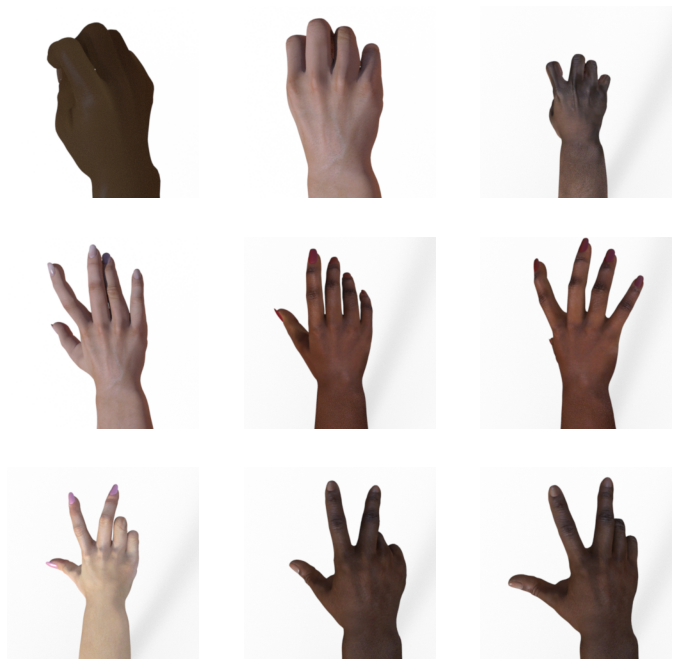

In [73]:
# Plot some training images from the dataset
nrows = 3
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

reset_random(seedNum)
number_elements = ncols
random_training_class1 = random.sample(training_class1_files, number_elements)
random_training_class2 = random.sample(training_class2_files, number_elements)
random_training_class3 = random.sample(training_class3_files, number_elements)
next_class1 = [os.path.join(training_class1_dir, fname) for fname in random_training_class1]
next_class2 = [os.path.join(training_class2_dir, fname) for fname in random_training_class2]
next_class3 = [os.path.join(training_class3_dir, fname) for fname in random_training_class3]

for i, img_path in enumerate(next_class1 + next_class2 + next_class3):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [70]:
print('Loading and pre-processing the training images...')
training_datagen = ImageDataGenerator(rescale=1/255)
# training_datagen = ImageDataGenerator(rescale=1./255,
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.1, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=False,  # randomly flip images
#     vertical_flip=False,  # randomly flip images
#     fill_mode='nearest')
training_generator = training_datagen.flow_from_directory(training_dir, target_size=default_image_size, batch_size=default_batch, class_mode='binary')
print('Number of image batches per epoch of modeling:', len(training_generator))

In [ ]:
print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=default_image_size, batch_size=default_batch, class_mode='binary')
print('Number of image batches per epoch of modeling:', len(validation_generator))

In [71]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
print ('Total time for the script:',(datetime.now() - startTimeScript))